# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [32]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [33]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

We are working to refine and improve Zillow’s Zestimate by building a predictive model that draws from property-level features to estimate a home’s tax value. Our job as analysts is not just to model the data but to tell a story that reveals what truly drives a home’s value. This means exploring what makes prices rise, what patterns show up across cities and zip codes, and how features like size, number of rooms, and property age shape market trends. The ultimate goal is to turn data into action, support the Zestimate’s accuracy, improve user trust, and give the marketing team a clearer view of which features matter most to potential buyers. When users feel confident in Zillow’s estimates, they are more likely to stay on the platform, explore listings, and take that next step toward buying or selling.


**1.2:**  How will your solution be used?

This solution will help users get a clearer picture of what their home is worth, whether they are thinking about selling, buying, or just exploring the market. By making price estimates more accurate and based on real features, the model gives people more confidence in the numbers they see. Zillow can also use it behind the scenes to improve the Zestimate over time. It helps the marketing team see what features matter most so they can highlight them better. And let’s be honest — it will also be used by bored graduate students checking how much their dream house might cost one day.



**1.3:**  How should success (or failure) be measured?

In simple terms, success means our predictions are close to the real tax values. We'll use metrics like mean absolute error to measure that. But as someone who’s used Zillow to browse fantasy homes in cities I’ll probably never live in, I’d say success also means the price feels believable. If it makes me pause and think “yeah, that makes sense,” then the model did its job. If it makes me laugh or gasp, something went wrong. A model that performs well on paper and feels right in practice is the real win — and if that gets us an A instead of a million dollars, I’ll take it.


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

### Step 1: Previewing the Zillow Dataset

To begin our exploration, we'll take a quick look at the first few rows of the dataset. This allows us to get familiar with the column names, the kinds of values they contain, and to start forming hypotheses about which features might be relevant for modeling.

We'll also pay attention to the target column, `taxvaluedollarcnt`, which represents the property's tax-assessed value in dollars. Our goal throughout this analysis is to understand how the other columns might help predict this target.


In [34]:
# Step 1: Take a quick look at the first few rows of the dataset
print("Displaying the first 5 rows of the Zillow dataset to get an overview of the structure and contents.\n")
df.head()


Displaying the first 5 rows of the Zillow dataset to get an overview of the structure and contents.



,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


This looks pretty typical for housing data. We have common features like bedroom count, bathroom count, and year built showing up consistently, while more specific details like basement size or deck type are often missing, which makes sense since not every home has those features.

### Step 2: Data Types and Missing Value Overview

Now that we've seen a preview of the data, the next step is to understand the structure of each column. We'll use `.info()` to get a summary that shows:

- The number of non-null entries in each column
- The inferred data type (e.g., float, int, object)
- Whether any columns are likely to need cleaning due to missing values or improper types

This step helps us decide which columns might need imputation, conversion, or removal.


In [35]:
# Step 2: Check the structure of the DataFrame
print("Getting information on each column, including data types and how many non-null values exist.\n")
df.info()


Getting information on each column, including data types and how many non-null values exist.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquaref

This gives a solid breakdown of each column. You can already see that some features like bathrooms, bedrooms, and square footage are almost fully filled out, which is great. But there are quite a few with heavy missing values, especially the more detailed or optional ones like basement size, fireplaces, and pools. Pretty normal for house data where not every home has those extras.

### Step 3: Counting Unique Values per Column

Next, we’ll count how many unique values are present in each column. This gives us insight into which columns might represent categories, identifiers, or potentially redundant features.

For example:
- A column with just one or two unique values might be a binary flag or a constant.
- A column with nearly as many unique values as rows might be an ID.

This step helps us prepare for deeper feature selection later.


In [36]:
# Step 3: Count how many unique values are in each column
print("Counting unique values per column to help identify potential categorical or ID-like features.\n")
df.nunique().sort_values(ascending=False)


Counting unique values per column to help identify potential categorical or ID-like features.



parcelid                        77414
latitude                        64038
longitude                       62461
taxvaluedollarcnt               50949
rawcensustractandblock          39188
censustractandblock             39006
lotsizesquarefeet               18848
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
propertyzoningdesc               1907
finishedsquarefeet50             1807
finishedfloor1squarefeet         1787
finishedsquarefeet15             1724
garagetotalsqft                   839
yardbuildingsqft17                540
regionidneighborhood              480
regionidzip                       389
finishedsquarefeet6               350
poolsizesum                       262
regionidcity                      175
yearbuilt                         136
propertycountylandusecode          75
yardbuildingsqft26                 59
basementsqft                       43
bathroomcnt                        22
calculatedbathnbr                  21
bedroomcnt  

This helps show which features are likely categorical and which might be IDs or constant. parcelid is almost entirely unique, so it's more of an identifier than something useful for modeling. Features with only one value like assessmentyear, fireplaceflag, or decktypeid probably won't help the model since they do not vary. On the other hand, things like regionidzip, propertylandusetypeid, and fips have a small number of repeating values, which makes them good candidates for categorical features. This gives a nice hint about which columns might be worth encoding or dropping.



### Step 4: Calculating Percent of Missing Values

Before we can confidently use these features in a model, we need to assess how complete each column is. High percentages of missing data may indicate a feature is unreliable or requires imputation.

In this step, we'll calculate the percentage of missing values in each column. This helps us:

- Identify features with very low availability that may not be worth keeping
- Flag potential issues for data cleaning or preprocessing
- Prioritize features that are more complete and potentially more useful



In [37]:
# Step 4: Calculate the percentage of missing values for each column
print("Calculating percentage of missing data in each column.\n")
missing_percent = df.isnull().mean().round(4) * 100
missing_percent.sort_values(ascending=False)


Calculating percentage of missing data in each column.



buildingclasstypeid             99.98
finishedsquarefeet13            99.95
basementsqft                    99.94
storytypeid                     99.94
yardbuildingsqft26              99.91
fireplaceflag                   99.78
architecturalstyletypeid        99.73
typeconstructiontypeid          99.71
finishedsquarefeet6             99.50
pooltypeid10                    99.40
decktypeid                      99.21
poolsizesum                     98.88
pooltypeid2                     98.62
hashottuborspa                  98.02
yardbuildingsqft17              96.92
taxdelinquencyyear              96.26
taxdelinquencyflag              96.26
finishedsquarefeet15            96.10
finishedsquarefeet50            92.22
finishedfloor1squarefeet        92.22
fireplacecnt                    89.32
threequarterbathnbr             86.98
pooltypeid7                     80.57
poolcnt                         79.16
numberofstories                 77.32
airconditioningtypeid           67.78
garagetotals

A lot of the optional or more detailed features are missing in over 90 percent of the dataset, like basement size, fireplace info, and extra pool details. That makes sense since most homes probably do not have those. The good news is that the core features like bathroom count, bedroom count, and square footage are mostly complete, which gives us a solid foundation to work with.

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

Categorical features are those with a limited number of distinct values. Based on the unique value counts and column names, likely categorical features include:

airconditioningtypeid (cooling system type)

architecturalstyletypeid (home style)

buildingclasstypeid (framing type)

buildingqualitytypeid (quality rating)

decktypeid (deck type)

heatingorsystemtypeid (heating system)

propertycountylandusecode (county land use code)

propertylandusetypeid (land use type)

propertyzoningdesc (zoning description)

regionidcity, regionidcounty, regionidzip, regionidneighborhood (location codes)

storytypeid (story type in multi-story home)

typeconstructiontypeid (construction material)

fireplaceflag (presence of fireplace)

taxdelinquencyflag (flag for overdue property taxes)

hashottuborspa (flag for hot tub or spa)

pooltypeid10, pooltypeid2, pooltypeid7 (pool types)

fips (county ID code)



Most of these columns contain either encoded numeric categories or textual codes representing property types, construction details, or zoning classifications.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

Some features honestly just do not seem helpful for predicting tax value. For example, parcelid is just a unique ID for each property. It is useful for tracking but does not tell us anything about the home itself. rawcensustractandblock and censustractandblock are very specific location codes that probably will not help much unless we are doing deep geographic analysis. Also, assessmentyear is the same for almost every row, so it is not really adding any value. These kinds of features do not give real insight into the property and would probably just clutter the model.


**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

Some features are missing in almost the entire dataset, which makes them hard to use in a general model. For example, features like buildingclasstypeid, finishedsquarefeet13, and basementsqft are over 99 percent missing, so they probably do not add much unless we are doing something very specific. Other features like fireplaceflag or decktypeid might still be useful, but only in certain cases like when the home actually has a fireplace or a deck. These feel more like add-on details that could help refine a Zestimate after the core features are already considered. So while they are not completely useless, the fact that they are missing for most properties makes them less useful for a model that needs to work broadly across the dataset.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Yes, some features stand out because of how many unique values they have, and not all of them seem helpful for modeling. `parcelid` has nearly one unique value per row, so it works more like a unique ID than a predictive feature. Features like `rawcensustractandblock` and `censustractandblock` also have tens of thousands of unique values and overlap with other location data we already have, such as `regionidzip`, `regionidcity`, `regionidcounty`, `latitude`, and `longitude`. While latitude and longitude could technically be useful, they have over 60,000 unique values each and are hard to use directly without transforming or grouping. Since we already have cleaner location codes, they might not be necessary unless we are doing something spatial.

On the opposite end, a few features have only one unique value across the whole dataset, including `decktypeid`, `storytypeid`, `poolcnt`, `pooltypeid7`, `pooltypeid10`, `pooltypeid2`, `fireplaceflag`, `assessmentyear`, and `taxdelinquencyflag`. Normally, we would consider features like that useless because they do not vary at all. However, since this project is focused on modeling something like a Zestimate, we should be cautious about removing them too quickly. Even if features like `fireplaceflag` or `pooltypeid2` are only present in a small number of homes, they could help fine-tune the value for those specific cases. So while some features like `parcelid` and detailed tract codes are safe to drop, others might still be useful if handled properly or used in specific conditions.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

### Part 2.B: Exploratory Data Analysis (EDA) — Feature-Level Visualization

We begin by generating histograms for all numeric features to get a general sense of the distributions in our dataset. This helps identify skewed variables, outliers, or any odd patterns that may require transformation or special handling during modeling.


Generating histograms for all numeric features to visualize distributions and spot potential outliers.


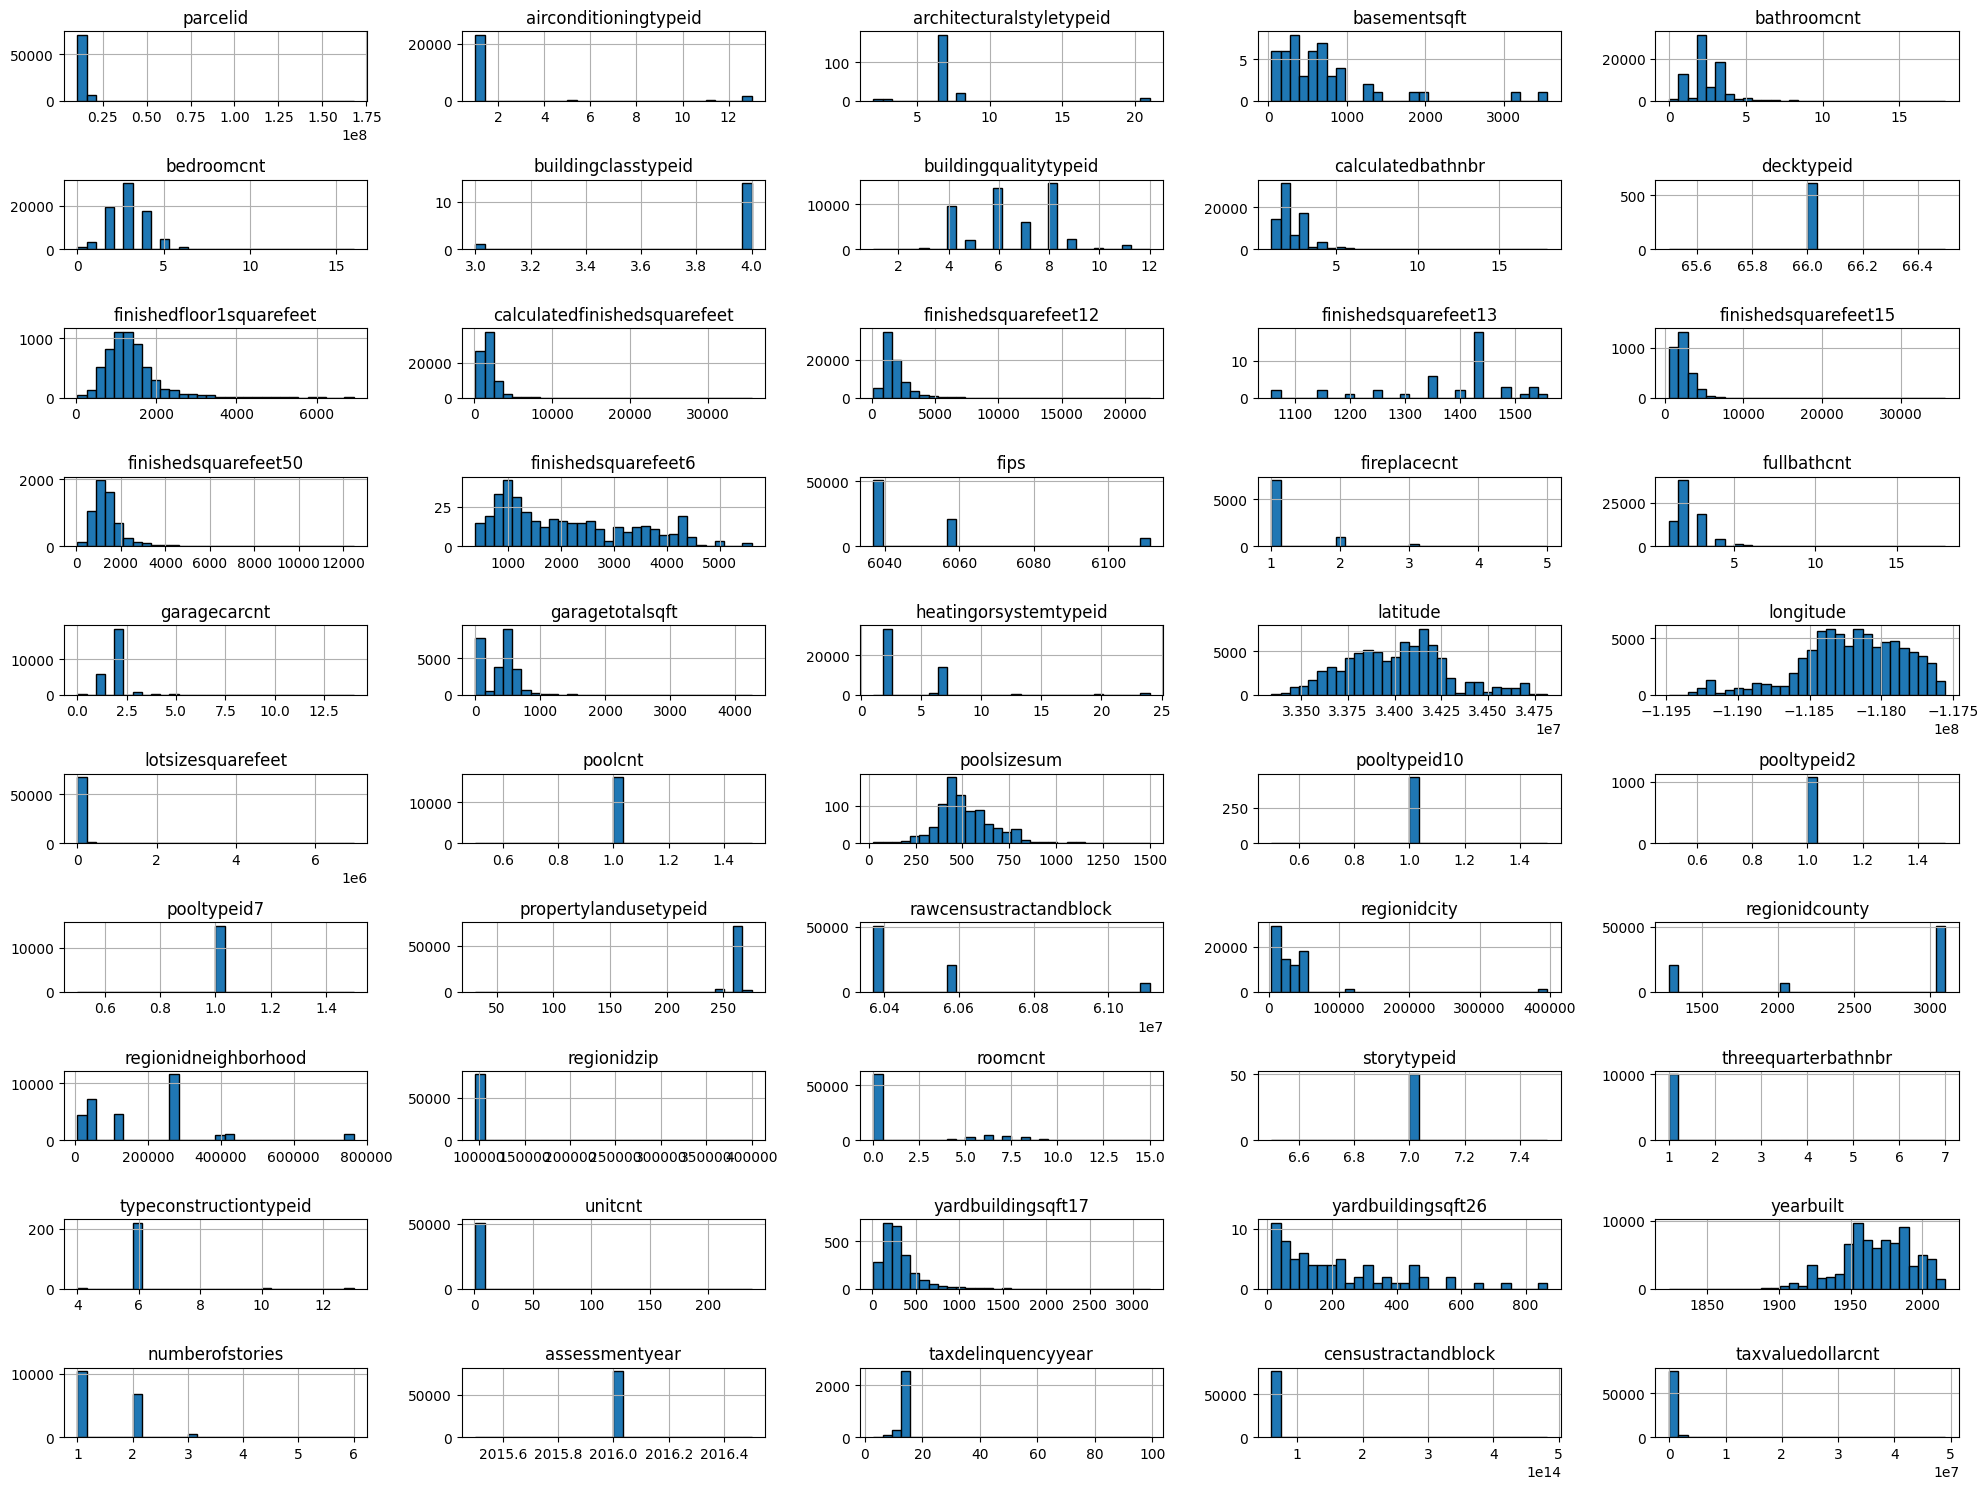

In [38]:
# Step 1: Histograms for all numeric columns to assess their distributions


print("Generating histograms for all numeric features to visualize distributions and spot potential outliers.")

df.hist(figsize=(20, 15), layout=(-1, 5), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()


This gives a good visual feel for the data. Most of the numerical features are right-skewed, especially things like tax value and square footage. A few features barely vary or have big gaps, like deck type or pool details, which we already expected. The spread in features like lot size and garage square footage is pretty wide too. Overall, nothing too surprising for housing data.

Now that we have an overview of the dataset using histograms, we will take a closer look at four important features:

- `taxvaluedollarcnt` (target)
- `calculatedfinishedsquarefeet` (total finished area)
- `bedroomcnt` (number of bedrooms)
- `regionidzip` (zip code as a location feature)

We’ll use histograms and boxplots to explore distributions and identify outliers or patterns.

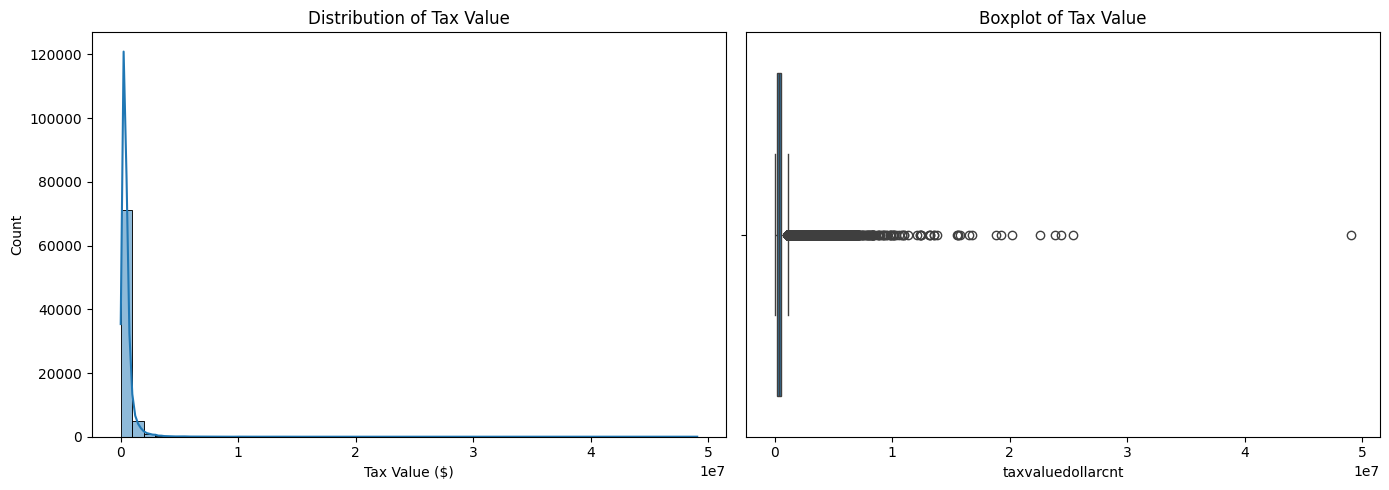

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
sns.histplot(df['taxvaluedollarcnt'], bins=50, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Tax Value')
axs[0].set_xlabel('Tax Value ($)')

# Boxplot
sns.boxplot(x=df['taxvaluedollarcnt'], ax=axs[1])
axs[1].set_title('Boxplot of Tax Value')

plt.tight_layout()
plt.show()


### Visualizing calculatedfinishedsquarefeet

This feature represents the total livable square footage of the property, which is often one of the most important predictors of property value. We'll use a histogram and a boxplot to assess its distribution and identify any unusual patterns or extreme values.


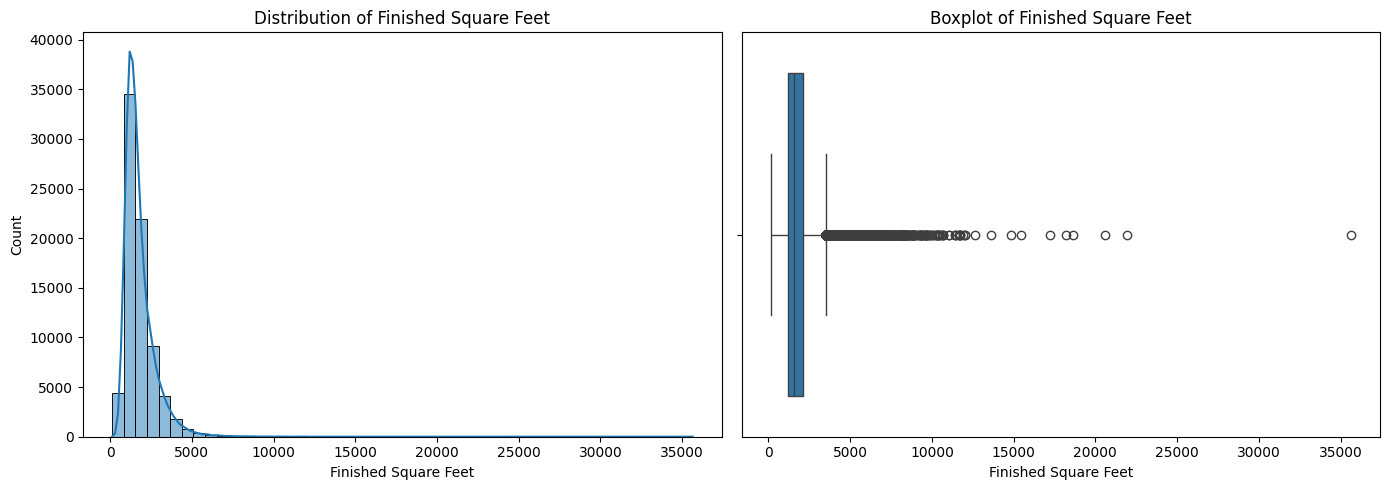

In [40]:
# Visualize the distribution of finished square feet
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
sns.histplot(df['calculatedfinishedsquarefeet'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Finished Square Feet")
axes[0].set_xlabel("Finished Square Feet")

# Boxplot
sns.boxplot(x=df['calculatedfinishedsquarefeet'], ax=axes[1])
axes[1].set_title("Boxplot of Finished Square Feet")
axes[1].set_xlabel("Finished Square Feet")

plt.tight_layout()
plt.show()


### Visualizing bathroomcnt

The `bathroomcnt` feature represents the number of bathrooms in a home. While it's a numeric column, it contains discrete values and behaves like a categorical variable. Homes with more bathrooms may be more valuable, but very high counts could be rare or outliers.

We'll use both a histogram and a boxplot to assess how the number of bathrooms is distributed and whether there are any unexpected or extreme values.


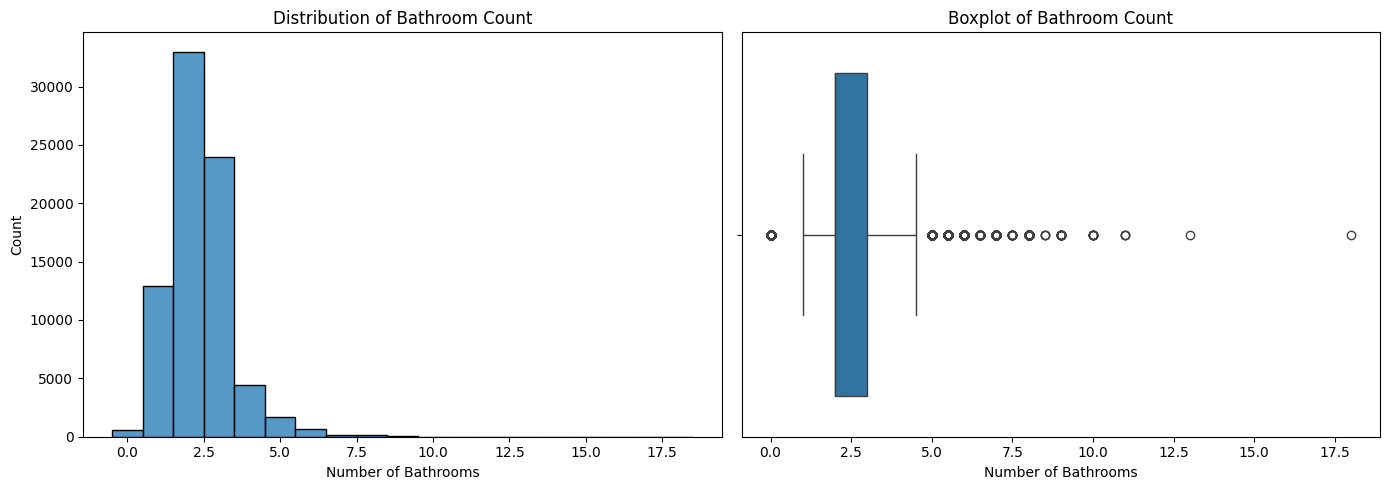

In [41]:
# Visualize the distribution of bathroom count
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
sns.histplot(df['bathroomcnt'], bins=20, kde=False, discrete=True, ax=axes[0])
axes[0].set_title("Distribution of Bathroom Count")
axes[0].set_xlabel("Number of Bathrooms")

# Boxplot
sns.boxplot(x=df['bathroomcnt'], ax=axes[1])
axes[1].set_title("Boxplot of Bathroom Count")
axes[1].set_xlabel("Number of Bathrooms")

plt.tight_layout()
plt.show()


### Visualizing regionidzip

This feature represents the zip code where the property is located. Since it is a categorical location variable, we’ll use a bar plot to show how many properties fall under each zip code. This can help us understand how the data is distributed geographically and whether certain areas are more represented in the dataset.


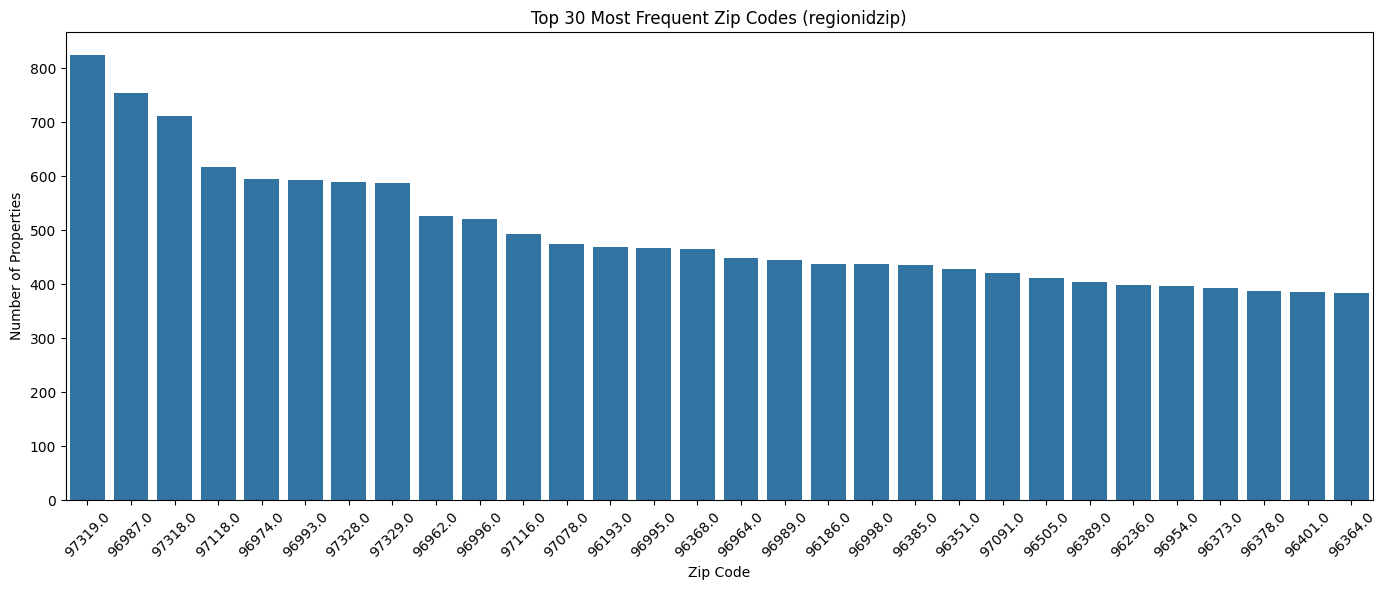

In [42]:
plt.figure(figsize=(14, 6))
zip_counts = df['regionidzip'].value_counts().sort_values(ascending=False).head(30)

sns.barplot(x=zip_counts.index.astype(str), y=zip_counts.values)
plt.title('Top 30 Most Frequent Zip Codes (regionidzip)')
plt.xlabel('Zip Code')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


#### 2.B Discussion

Looking closely at the four features, I noticed that both taxvaluedollarcnt and calculatedfinishedsquarefeet have highly skewed distributions. Most homes fall on the lower end, but a few properties have extremely high values or large square footage. These outliers might need special attention when building the model. The bedroomcnt feature is more balanced, with most homes having between two and four bedrooms, which makes sense. The regionidzip feature shows that some zip codes are much more common in the dataset than others, meaning the data is not evenly spread out across locations. That could affect the model if location becomes too influential. I chose these features because they reflect what I believe most people pay attention to when searching for a home. Price, size, layout, and location are often the first things buyers look at, so it makes sense to focus on those when trying to estimate a property's value.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [43]:
df.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

In [44]:
df_clean = df.drop(columns=['parcelid', 'latitude', 'longitude', 'rawcensustractandblock', 'censustractandblock', 'regionidzip', 'regionidcity', 'regionidcounty', 'assessmentyear'])
df_clean.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,taxdelinquencyflag,taxdelinquencyyear,taxvaluedollarcnt
0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,...,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,NaN,NaN,1023282.0
1,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,...,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,NaN,NaN,464000.0
2,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,NaN,NaN,564778.0
3,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,NaN,NaN,145143.0
4,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,NaN,NaN,119407.0


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


Columns dropped: 'parcelid', 'latitude', 'longitude', 'rawcensustractandblock', 'censustractandblock', 'regionidzip', 'regionidcity', 'regionidcounty', 'assessmentyear'

Parcelid is a column that serves as a unique identifier, therefore it's not relevenat for predicetive analysis or regression. Latitude and longitude ended up dropped as they serve as geographic coordinates; while that might sound useful, that also contains too many unique values that it would not be helpful. Columns rawcensustractandblock and censustractandblock aren't relevant in regression either, as they also contain too many unique values. Regionidzip, regionidcity and regionidcounty are columns are it states its unqiue region zip/city/county, also containing too many unique values. Assessmentyear isn't releveant either, since the value changes in each row are too minimal.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [45]:
df_clean = df_clean.drop(columns=['buildingclasstypeid', 'finishedsquarefeet13','finishedsquarefeet15',
                                    'finishedsquarefeet50','basementsqft', 'storytypeid',
                                  'yardbuildingsqft26','yardbuildingsqft17','pooltypeid10','pooltypeid2',
                                  'poolsizesum','fireplaceflag', 'architecturalstyletypeid',
                                  'typeconstructiontypeid','finishedsquarefeet6','decktypeid','hashottuborspa',
                                  'taxdelinquencyyear', 'taxdelinquencyflag','finishedfloor1squarefeet',
                                  'fireplacecnt', 'threequarterbathnbr','poolcnt','pooltypeid7','airconditioningtypeid',
                                  'numberofstories', 'garagecarcnt','garagetotalsqft','regionidneighborhood',
                                  'propertyzoningdesc'])
df_clean.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,3.0,NaN,4506.0,122,261.0,0.0,NaN,1998.0,1023282.0
1,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,NaN,12647.0,1110,261.0,5.0,NaN,1967.0,464000.0
2,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,NaN,8432.0,122,261.0,6.0,NaN,1962.0,564778.0
3,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,13038.0,0101,261.0,0.0,1.0,1970.0,145143.0
4,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,278581.0,010C,266.0,0.0,1.0,1964.0,119407.0


In [46]:
print("Calculating percentage of missing data in each column.\n")
missing_percent = df_clean.isnull().mean().round(4) * 100
missing_percent.sort_values(ascending=False)

Calculating percentage of missing data in each column.



heatingorsystemtypeid           36.13
buildingqualitytypeid           35.82
unitcnt                         34.67
lotsizesquarefeet               10.68
finishedsquarefeet12             4.75
fullbathcnt                      0.84
calculatedbathnbr                0.84
yearbuilt                        0.39
calculatedfinishedsquarefeet     0.30
taxvaluedollarcnt                0.05
bedroomcnt                       0.04
bathroomcnt                      0.04
fips                             0.04
propertycountylandusecode        0.04
propertylandusetypeid            0.04
roomcnt                          0.04
dtype: float64

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



Many features have been removed from the dataset. Examined in Part 1, we looked at the percentage of missing values in each columns. A large amount of columns hold above 90% of missing values. For a dataset the contains over 77,000 rows, too many missing values make it difficult to use in a general model. As stated in Part 1, features like buildingclasstypeid, finishedsquarefeet13, and basementsqft are over 99 percent missing, practically the entire dataset. They do not hold much use, as goes for the rest of the feautres that hold a high percentage of missing values. After removing these features, we examined the percentage of missing values again, which show a much less percentage.

Features removed: 'buildingclasstypeid', 'finishedsquarefeet13','finishedsquarefeet15' 'finishedsquarefeet50','basementsqft', 'storytypeid', 'yardbuildingsqft26','yardbuildingsqft17','pooltypeid10','pooltypeid2','poolsizesum','fireplaceflag', 'architecturalstyletypeid', 'typeconstructiontypeid','finishedsquarefeet6','decktypeid','hashottuborspa',
'taxdelinquencyyear', 'taxdelinquencyflag','finishedfloor1squarefeet',
'fireplacecnt', 'threequarterbathnbr','poolcnt','pooltypeid7','airconditioningtypeid',
'numberofstories', 'garagecarcnt','garagetotalsqft','regionidneighborhood',
'propertyzoningdesc'

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [47]:
q1 = df_clean['taxvaluedollarcnt'].quantile(0.25)
q3 = df_clean['taxvaluedollarcnt'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df_clean[(df_clean['taxvaluedollarcnt'] >= lower_bound) &(df_clean['taxvaluedollarcnt'] <= upper_bound)]

In [48]:
print("Rows Size Before:", df_clean.shape)
print("Row Size After:", df.shape)

Rows Size Before: (77613, 16)
Row Size After: (72392, 16)


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


Essentially what was done was detected outliers of the target (taxvaluedollarcnt) using the IQR method. Using the IDR method ranging from the 25th percentile to the 75th percentile of the data, it keeps the middle 50% of the data. Since this column is skewed, it helps with this distribution. After applying the method, it removed roughly 5000 rows of the data, lowering the shape from about 77,000 rows to 72,000 rows.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [49]:
df['heatingorsystemtypeid'].fillna(-1, inplace=True)
df['buildingqualitytypeid'].fillna(df['buildingqualitytypeid'].median(), inplace=True)
df['unitcnt'].fillna(1, inplace=True)
df['lotsizesquarefeet'].fillna(df['lotsizesquarefeet'].median(), inplace=True)
df.head()

/tmp/ipykernel_2326/982627946.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heatingorsystemtypeid'].fillna(-1, inplace=True)
/tmp/ipykernel_2326/982627946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heatingorsystemtypeid'].fillna(-1, inplace=True)
/tmp/ipykernel_2326/982627946.py:2: FutureWarning: A value is trying to be 

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,-1.0,4506.0,122,261.0,0.0,1.0,1998.0,1023282.0
1,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,1.0,-1.0,12647.0,1110,261.0,5.0,1.0,1967.0,464000.0
2,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,2.0,-1.0,8432.0,122,261.0,6.0,1.0,1962.0,564778.0
3,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,13038.0,0101,261.0,0.0,1.0,1970.0,145143.0
4,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,278581.0,010C,266.0,0.0,1.0,1964.0,119407.0


In [50]:
missing_percent = df.isnull().mean().round(4) * 100
missing_percent.sort_values(ascending=False)

finishedsquarefeet12            4.67
calculatedbathnbr               0.72
fullbathcnt                     0.72
yearbuilt                       0.29
calculatedfinishedsquarefeet    0.20
buildingqualitytypeid           0.00
bathroomcnt                     0.00
bedroomcnt                      0.00
fips                            0.00
heatingorsystemtypeid           0.00
propertycountylandusecode       0.00
lotsizesquarefeet               0.00
propertylandusetypeid           0.00
roomcnt                         0.00
unitcnt                         0.00
taxvaluedollarcnt               0.00
dtype: float64

In [51]:
df = df.dropna()
df.shape

(68872, 16)

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


A few imputation methods were used, not too many: for the column 'buildingqualitytypeid' and 'lotsizesquarefeet', the missing values were essentially filled with the median of those columns. Buildingqualitytypeid is a subjective score, if using the mean could possibly be skewed with outliers, therefore it was safer to use the median to fill them in.Lotsizesquarefeet is a continous column, and the lot size can vary which can be skewed, therefore median is a better option. Unitcnt was filled with 1 since based on the data, it is a residential area so the unit count is most likely 1, which is a good option to fill the missing values. Heatingorsystemtypeid was filled with -1 since it marks as unknown. It is a categorical ID, where 1 = central and 2 = floor heater. With the value missing, -1 serves as a placeholder for unknown. 

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

##### The remaining columns are numerical, therefore no encode is required on this step.

In [52]:
df.shape

(68872, 16)

In [53]:
df.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,-1.0,4506.0,122,261.0,0.0,1.0,1998.0,1023282.0
1,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,1.0,-1.0,12647.0,1110,261.0,5.0,1.0,1967.0,464000.0
2,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,2.0,-1.0,8432.0,122,261.0,6.0,1.0,1962.0,564778.0
3,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,13038.0,0101,261.0,0.0,1.0,1970.0,145143.0
4,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,278581.0,010C,266.0,0.0,1.0,1964.0,119407.0


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

Correlation matrix:

In [54]:
cm = df.corr(numeric_only=True)
cm

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,lotsizesquarefeet,propertylandusetypeid,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
bathroomcnt,1.000000,0.556216,0.474296,1.000000,0.747014,0.747014,0.066223,0.977390,-0.274699,0.014257,0.050755,0.078949,0.012808,0.462113,0.424727
bedroomcnt,0.556216,1.000000,0.097599,0.556216,0.682782,0.682782,0.100599,0.544061,-0.173878,-0.100894,-0.413801,0.241100,0.014940,0.075444,0.250701
buildingqualitytypeid,0.474296,0.097599,1.000000,0.474296,0.305323,0.305323,-0.144283,0.499824,-0.223782,0.136422,0.321890,-0.135618,-0.000380,0.431092,0.209640
calculatedbathnbr,1.000000,0.556216,0.474296,1.000000,0.747014,0.747014,0.066223,0.977390,-0.274699,0.014257,0.050755,0.078949,0.012808,0.462113,0.424727
calculatedfinishedsquarefeet,0.747014,0.682782,0.305323,0.747014,1.000000,1.000000,0.100247,0.721903,-0.235022,-0.058424,-0.258994,0.175119,0.014276,0.255944,0.493321
finishedsquarefeet12,0.747014,0.682782,0.305323,0.747014,1.000000,1.000000,0.100247,0.721903,-0.235022,-0.058424,-0.258994,0.175119,0.014276,0.255944,0.493321
fips,0.066223,0.100599,-0.144283,0.066223,0.100247,0.100247,1.000000,-0.015528,-0.387245,-0.099222,-0.016836,0.714678,-0.002701,0.218998,0.094167
fullbathcnt,0.977390,0.544061,0.499824,0.977390,0.721903,0.721903,-0.015528,1.000000,-0.226180,0.029132,0.042936,0.016273,0.013972,0.412179,0.395440
heatingorsystemtypeid,-0.274699,-0.173878,-0.223782,-0.274699,-0.235022,-0.235022,-0.387245,-0.226180,1.000000,-0.008544,-0.015685,-0.273182,-0.000061,-0.348869,-0.174074
lotsizesquarefeet,0.014257,-0.100894,0.136422,0.014257,-0.058424,-0.058424,-0.099222,0.029132,-0.008544,1.000000,0.215603,-0.092547,-0.000637,0.088045,-0.044703


Correlation matrix visual:

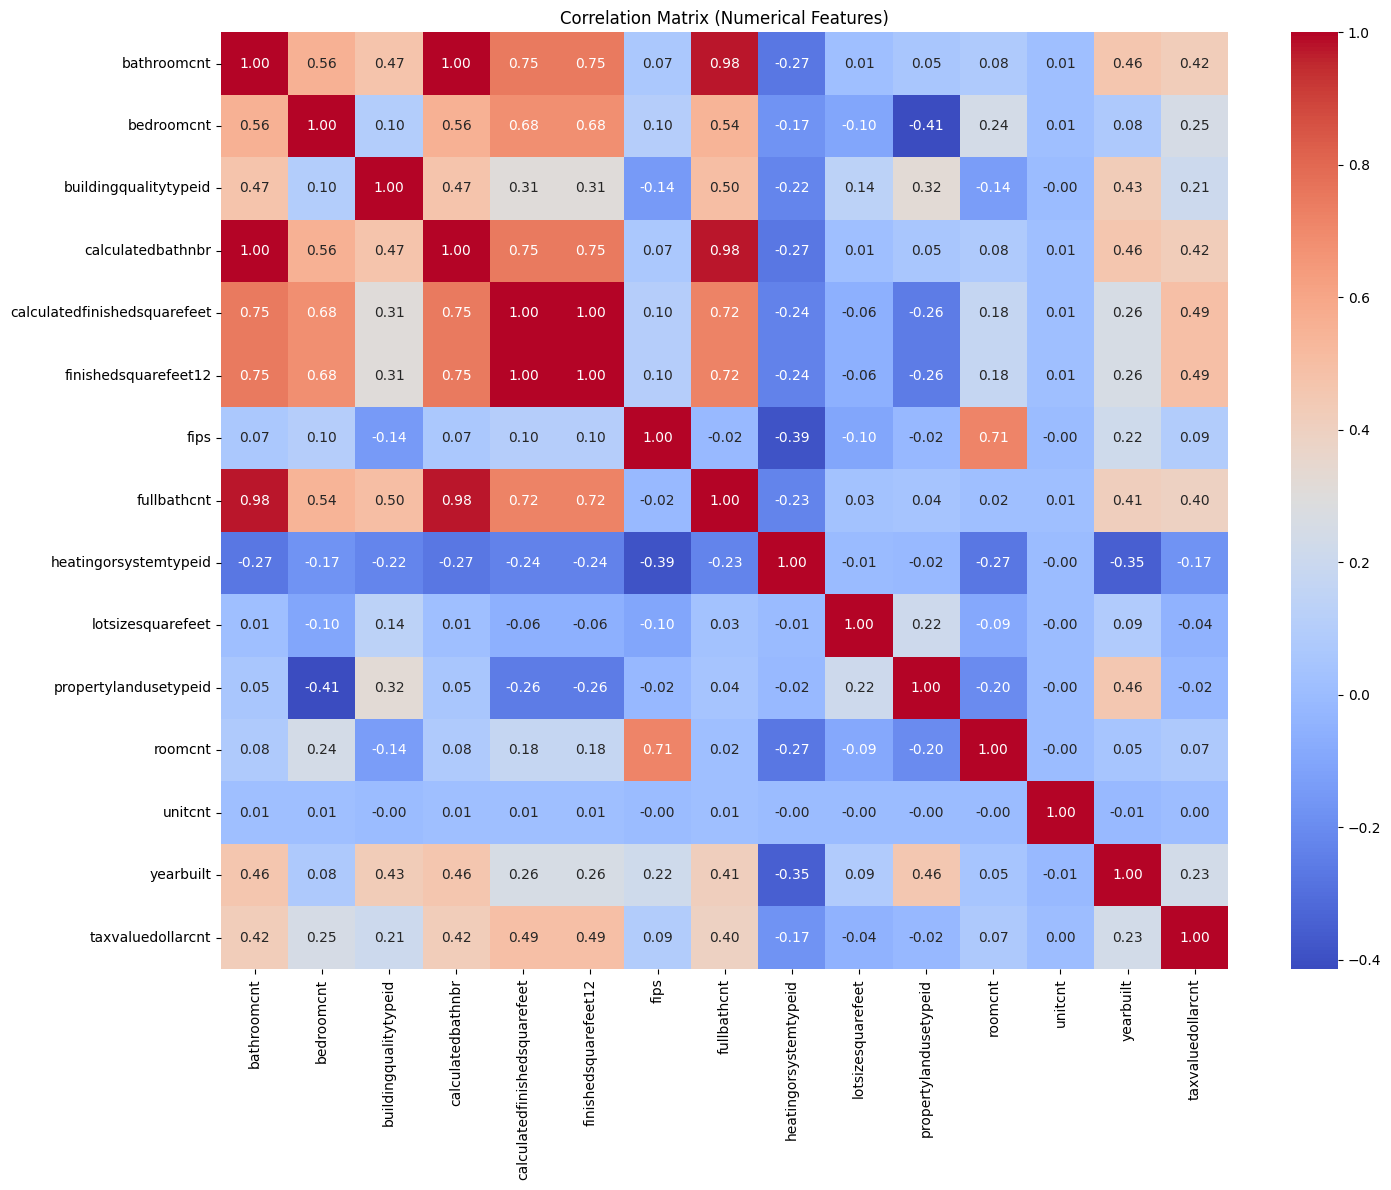

In [55]:

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()

F-Statistic:

/tmp/ipykernel_2326/1585309868.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=f_stat_df.head(15), x='F-Score', y='Feature', palette='viridis')


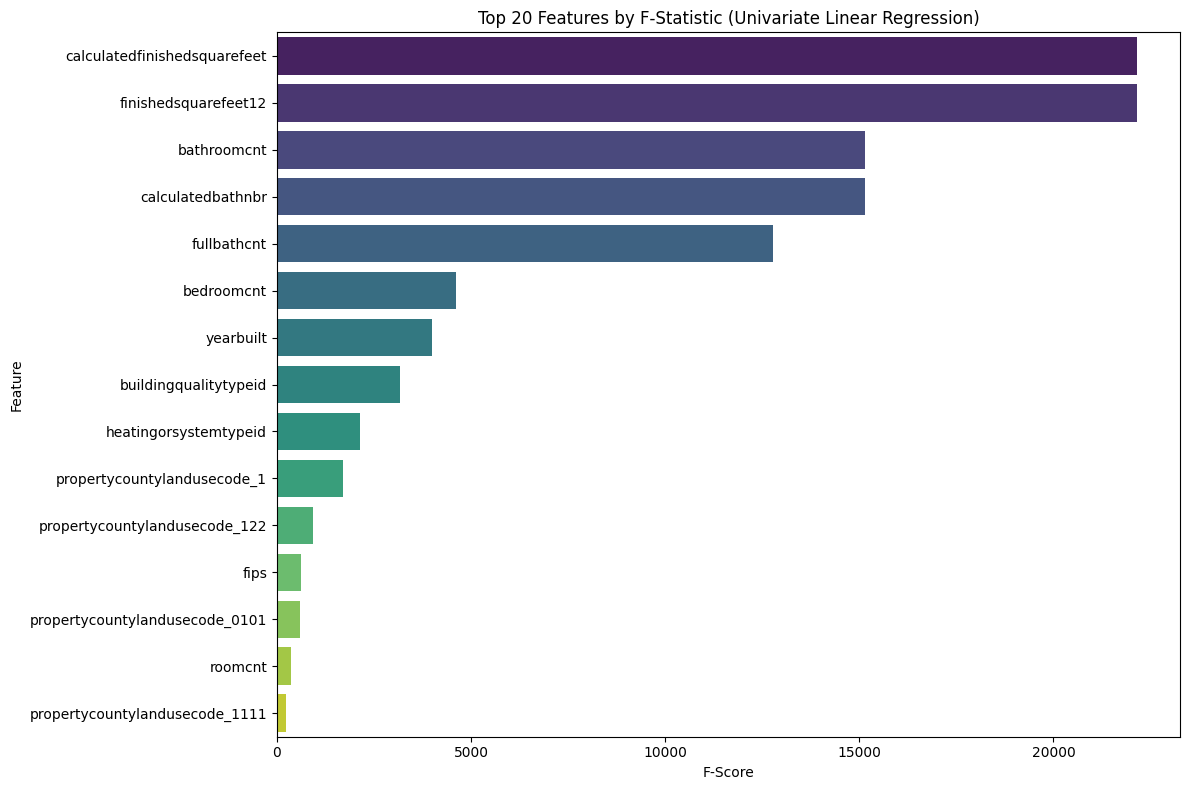

In [56]:
X = df.drop(columns=['taxvaluedollarcnt'])
y = df['taxvaluedollarcnt']
X_encoded = pd.get_dummies(X, drop_first=True)
f_scores, p_values = f_regression(X_encoded, y)
f_stat_df = pd.DataFrame({'Feature': X_encoded.columns,'F-Score': f_scores})
f_stat_df = f_stat_df.sort_values(by='F-Score', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=f_stat_df.head(15), x='F-Score', y='Feature', palette='viridis')
plt.title('Top 20 Features by F-Statistic (Univariate Linear Regression)')
plt.tight_layout()
plt.show()

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



With taxvaluedollarcnt being the target, there aren't many strong correlations with this feautre

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

